In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import joblib

#first load data
missing_vals = [' ?', 'n/a', '--', 'na', 'NaN', '', ' ']
dataset = pd.read_csv('./data/Glorad.csv', encoding = 'utf-8-sig', header = 0, na_values = missing_vals)
dataset.head()

,LOCATION,DATE,GLORAD,meant,maxtp,mintp,mnmax,mnmin,rain,gmin,wdsp,maxgt
0,BELMULLET,01/01/2012,6114,7.9,11.7,1.4,10.1,5.7,123.6,-2.2,14.2,72.0
1,BELMULLET,01/02/2012,9324,8.4,12.1,-1.0,10.0,6.8,69.4,-4.2,12.8,49.0
2,BELMULLET,01/03/2012,27674,9.6,22.2,1.8,12.6,6.5,41.4,-2.2,11.8,51.0
3,BELMULLET,01/04/2012,45504,8.1,13.6,0.7,11.4,4.9,79.7,-2.6,10.6,49.0
4,BELMULLET,01/05/2012,54903,11.8,26.1,0.6,15.4,8.2,52.1,-2.2,10.1,49.0


In [6]:
data_dict

,NAME,DEFINITION,DATA TYPE,UNIT
0,LOCATION,Location of weather station,object,
1,DATE,Date,object,
2,GLORAD,Global Irradiance,int64,J/Cm2
3,meant,Mean temperature,float64,°C
4,maxtp,Precipitation Amount,float64,mm
5,mintp,Maximum Air Temperature,float64,°C
6,mnmax,Minimum Air Temperature,float64,°C
7,mnmin,Mean Maximum Temperature,float64,°C
8,rain,Mean Minimum Temperature,float64,°C
9,gmin,Grass Minimum Temperature,float64,°C


In [2]:
#Data Quality Report

In [3]:
#ABT CONTINUOUS
continuous_feature_names = list(dataset.columns.values)
continuous_feature_names.remove('LOCATION')
continuous_feature_names.remove('DATE')
continuous_feature_rows = []
continuous_headings = ['FEATURENAME', 'Count', '% Miss.', 'Card.', 'Min', '1st Qrt', 'Mean', 'Median', '3rd Qrt', 'Max', 'Std. Dev.']
#Continuous
for feature in continuous_feature_names:
    continuous_feature_rows.append([
        feature,
        dataset[feature].count(),
        round((dataset[feature].isnull().sum() / dataset[feature].count()) * 100, 2),
        len(dataset[feature].unique()),
        dataset[feature].min(),
        dataset[feature].quantile(0.25),
        dataset[feature].mean(),
        dataset[feature].quantile(0.5),
        dataset[feature].quantile(0.75),
        dataset[feature].max(),
        dataset[feature].std()        
    ])
    
continuous_features = pd.DataFrame(continuous_feature_rows, columns = continuous_headings)
continuous_features

,FEATURENAME,Count,% Miss.,Card.,Min,1st Qrt,Mean,Median,3rd Qrt,Max,Std. Dev.
0,GLORAD,696,0.0,690,3140.0,10611.250,29147.086207,28161.50,45725.0,68134.0,18324.253401
1,meant,696,0.0,141,2.8,7.000,9.997055,9.60,13.2,17.5,3.550290
2,maxtp,696,0.0,176,8.9,13.775,17.840374,17.40,21.6,30.1,4.604747
3,mintp,696,0.0,176,-7.9,-1.525,1.551293,1.05,4.7,11.5,4.097305
4,mnmax,696,0.0,149,5.9,9.800,13.191020,12.85,16.6,23.0,3.861326
5,mnmin,696,0.0,139,-0.3,4.000,6.806609,6.30,9.9,13.9,3.432251
6,rain,696,0.0,575,4.8,57.325,95.667744,86.70,123.1,339.0,52.569869
7,gmin,696,0.0,185,-12.6,-5.400,-2.110201,-2.30,1.0,8.7,4.389840
8,wdsp,696,0.0,148,3.5,7.800,10.200216,9.70,12.2,22.3,3.375252
9,maxgt,696,0.0,58,21.0,37.000,44.821121,44.00,52.0,91.0,10.486780


In [4]:
#ABT CATEGORICAL
categorical_headings = ['FEATURENAME', 'Count', '% Miss.', 'Card.', 'Mode', 'Mode Freq.', 'Mode %', '2nd Mode', '2nd Mode Freq', '2nd Mode %']
categorical_feature_names = ['LOCATION', 'DATE']
categorical_feature_rows = []

for feature in categorical_feature_names:
    categorical_feature_rows.append([
        feature,
        dataset[feature].count(),
        round((dataset[feature].isna().sum() / dataset[feature].count()) * 100, 2),
        len(dataset[feature].unique()),
        dataset[feature].value_counts().index.tolist()[0],
        dataset[feature].value_counts()[0],      
        round((dataset[feature].value_counts()[0] / dataset[feature].count()) * 100, 2),
        dataset[feature].value_counts().index.tolist()[1],
        dataset[feature].value_counts()[1],      
        round((dataset[feature].value_counts()[1] / dataset[feature].count()) * 100, 2),    
    ])

categorical_features = pd.DataFrame(categorical_feature_rows, columns = categorical_headings)
categorical_features

,FEATURENAME,Count,% Miss.,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
0,LOCATION,696,0.0,6,BELMULLET,116,16.67,BIRR,116,16.67
1,DATE,696,0.0,116,01/01/2012,6,0.86,01/02/2018,6,0.86


In [5]:
#DATA DICTIONARY
dataset_column_names = []
definitions = []
data_dict_rows = []
dataset_column_names = list(dataset.columns.values)

definitions = ['Location of weather station','Date','Global Irradiance','Mean temperature','Precipitation Amount',
'Maximum Air Temperature','Minimum Air Temperature','Mean Maximum Temperature','Mean Minimum Temperature',
'Grass Minimum Temperature','Mean Wind Speed','Highest Gust']

units = ['','','J/Cm2','°C','mm','°C','°C','°C','°C','°C','knot','knot']
data_dict_rows = []
data_dict_headings = ['NAME', 'DEFINITION', 'DATA TYPE', 'UNIT']

for i, colname in enumerate(dataset_column_names):
    data_dict_rows.append([
        colname,
        definitions[i],
        list([x.name for x in dataset.dtypes])[i],
        units[i],
    ])

data_dict = pd.DataFrame(data_dict_rows, columns=data_dict_headings)

In [6]:
#EXPLORATORY ANALYSIS

In [7]:
#New dataframe for exploratory analysis
exploratory_df = dataset.copy()
exploratory_df['DATE'] = pd.to_datetime(exploratory_df['DATE'], dayfirst=True)
exploratory_df = exploratory_df.set_index("DATE")
exploratory_df.index = pd.DatetimeIndex(exploratory_df.index)

exploratory_df['YEAR'] = exploratory_df.index.year
exploratory_df['MONTH'] = exploratory_df.index.month
exploratory_df['MONTH2'] = exploratory_df.index.month_name().str.slice(stop=3)

In [8]:
#HISTOGRAMS

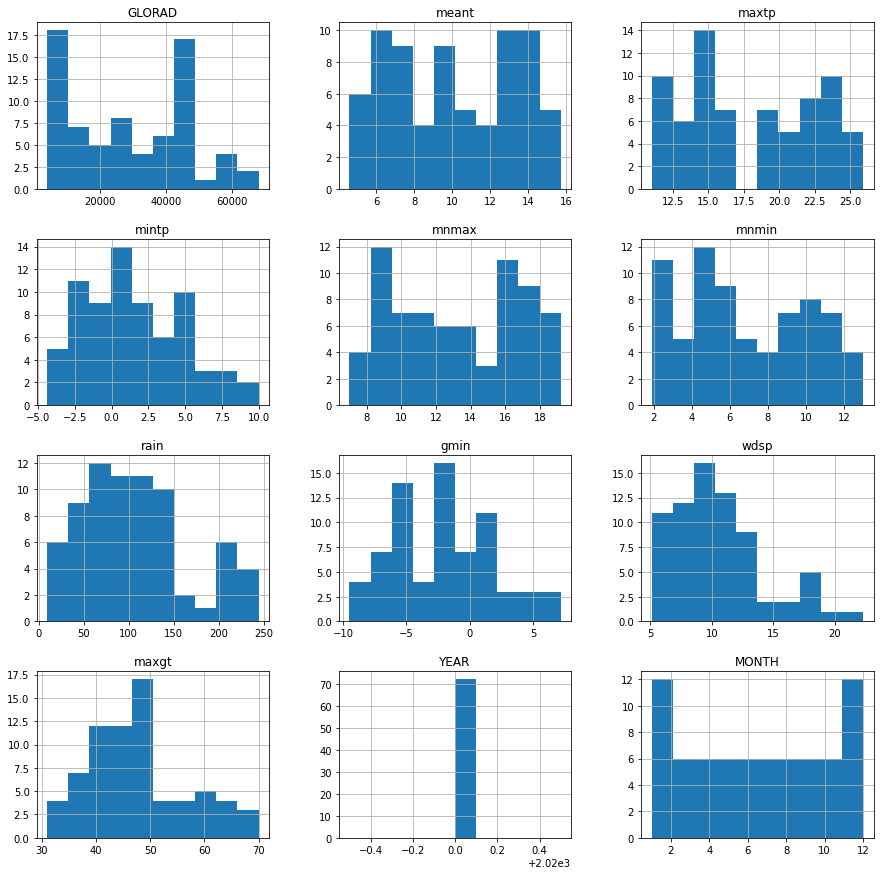

In [9]:
hist = exploratory_df[exploratory_df['YEAR'] == 2020].hist(bins=10, figsize=(15,15))

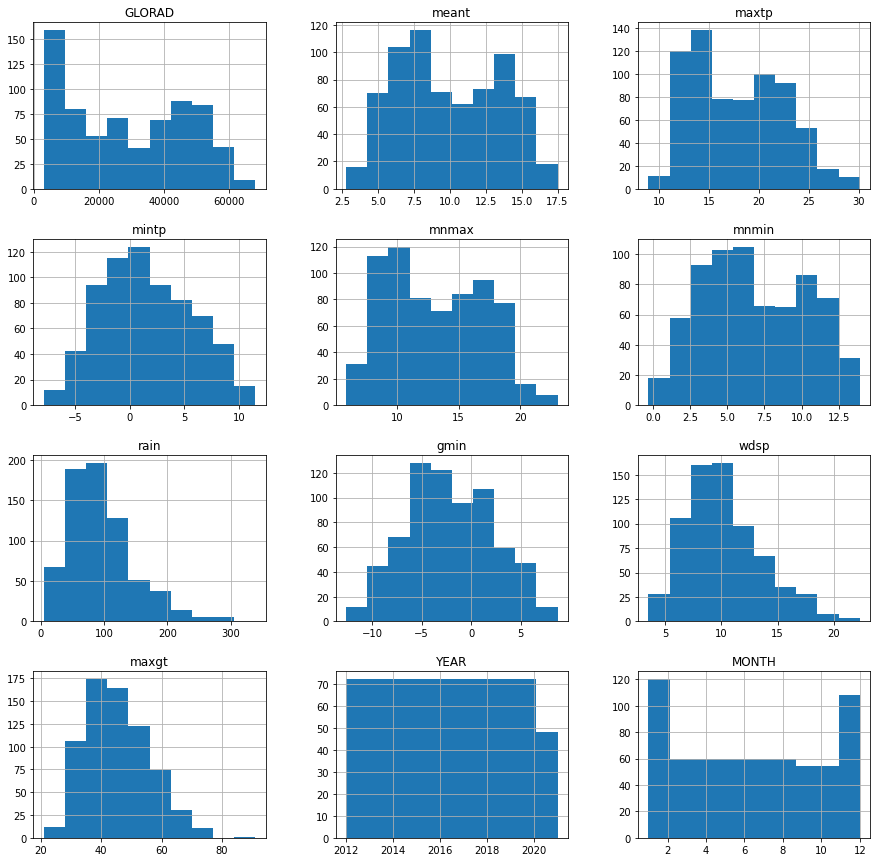

In [10]:
hist = exploratory_df.hist(bins=10, figsize=(15,15))

In [11]:
#BOXPLOTS

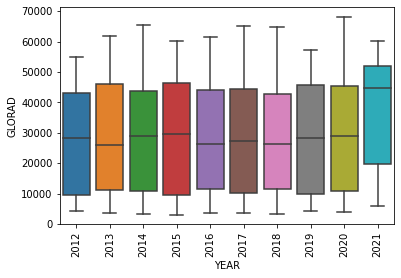

In [12]:
ax = sns.boxplot(data = exploratory_df, x='YEAR',y=('GLORAD'))
for item in ax.get_xticklabels():
    item.set_rotation(90)

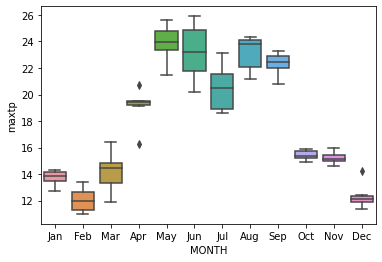

In [13]:
ax = sns.boxplot(data = exploratory_df[exploratory_df['YEAR'] == 2020], x='MONTH2',y=('maxtp')).set(xlabel='MONTH')

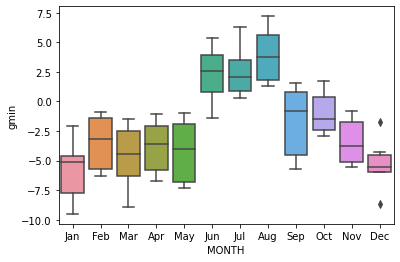

In [14]:
ax = sns.boxplot(data = exploratory_df[exploratory_df['YEAR'] == 2020], x='MONTH2',y=('gmin')).set(xlabel='MONTH')

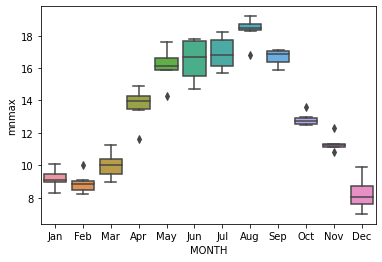

In [15]:
ax = sns.boxplot(data = exploratory_df[exploratory_df['YEAR'] == 2020], x='MONTH2',y=('mnmax')).set(xlabel='MONTH')

array([[<AxesSubplot:xlabel='GLORAD', ylabel='GLORAD'>,
        <AxesSubplot:xlabel='meant', ylabel='GLORAD'>,
        <AxesSubplot:xlabel='maxtp', ylabel='GLORAD'>,
        <AxesSubplot:xlabel='mintp', ylabel='GLORAD'>,
        <AxesSubplot:xlabel='mnmax', ylabel='GLORAD'>,
        <AxesSubplot:xlabel='mnmin', ylabel='GLORAD'>,
        <AxesSubplot:xlabel='rain', ylabel='GLORAD'>,
        <AxesSubplot:xlabel='gmin', ylabel='GLORAD'>,
        <AxesSubplot:xlabel='wdsp', ylabel='GLORAD'>,
        <AxesSubplot:xlabel='maxgt', ylabel='GLORAD'>],
       [<AxesSubplot:xlabel='GLORAD', ylabel='meant'>,
        <AxesSubplot:xlabel='meant', ylabel='meant'>,
        <AxesSubplot:xlabel='maxtp', ylabel='meant'>,
        <AxesSubplot:xlabel='mintp', ylabel='meant'>,
        <AxesSubplot:xlabel='mnmax', ylabel='meant'>,
        <AxesSubplot:xlabel='mnmin', ylabel='meant'>,
        <AxesSubplot:xlabel='rain', ylabel='meant'>,
        <AxesSubplot:xlabel='gmin', ylabel='meant'>,
        <AxesSubplot

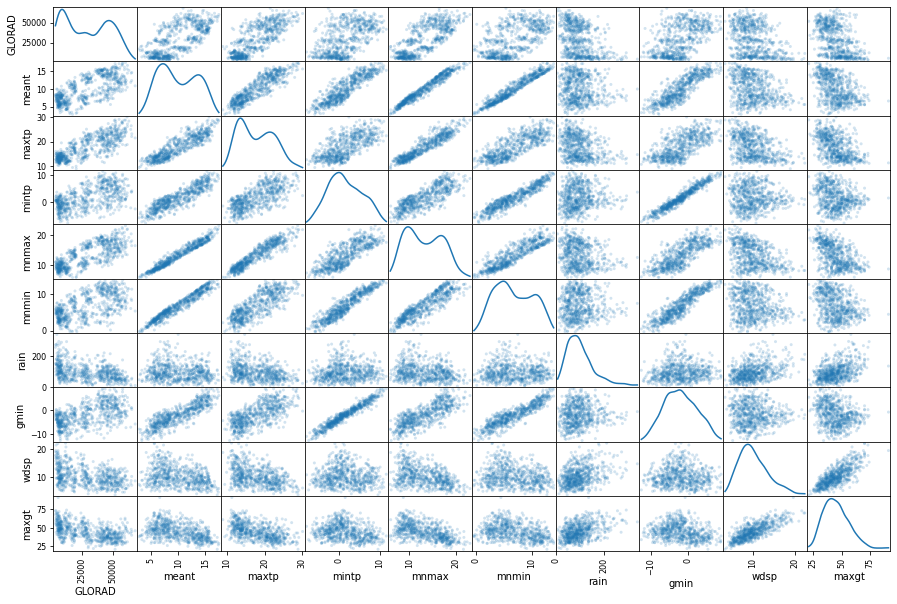

In [16]:
#SCATTER PLOTS
pd.plotting.scatter_matrix(dataset[list(dataset.columns.values)], alpha=0.2, diagonal='kde', figsize=(15, 10))

In [17]:
#CORRELATION MATRIX
gd_correlation_matrix = dataset.corr()
gd_correlation_matrix

,GLORAD,meant,maxtp,mintp,mnmax,mnmin,rain,gmin,wdsp,maxgt
GLORAD,1.000000,0.699104,0.793359,0.559435,0.761668,0.588525,-0.397347,0.543137,-0.368909,-0.495241
meant,0.699104,1.000000,0.892672,0.890723,0.976971,0.970520,-0.106834,0.863861,-0.311591,-0.452480
maxtp,0.793359,0.892672,1.000000,0.697734,0.934054,0.795853,-0.309158,0.674894,-0.420477,-0.510620
mintp,0.559435,0.890723,0.697734,1.000000,0.804933,0.938355,0.072086,0.968069,-0.052501,-0.252371
mnmax,0.761668,0.976971,0.934054,0.804933,1.000000,0.896932,-0.205360,0.778866,-0.410960,-0.530062
mnmin,0.588525,0.970520,0.795853,0.938355,0.896932,1.000000,0.011125,0.912143,-0.182371,-0.339888
rain,-0.397347,-0.106834,-0.309158,0.072086,-0.205360,0.011125,1.000000,0.081506,0.358458,0.424549
gmin,0.543137,0.863861,0.674894,0.968069,0.778866,0.912143,0.081506,1.000000,-0.042835,-0.240220
wdsp,-0.368909,-0.311591,-0.420477,-0.052501,-0.410960,-0.182371,0.358458,-0.042835,1.000000,0.771041
maxgt,-0.495241,-0.452480,-0.510620,-0.252371,-0.530062,-0.339888,0.424549,-0.240220,0.771041,1.000000


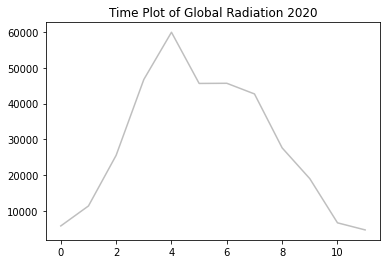

In [18]:
#Plotting the values to see the shape
fig, ac = plt.subplots()
yearly_df = exploratory_df[exploratory_df['YEAR']==2020]
yearly_df = yearly_df[yearly_df['LOCATION']=='BELMULLET']
ac.plot(np.arange(len(yearly_df.index)), 'GLORAD', data=yearly_df, color='0.75')
ac.set_title('Time Plot of Global Radiation 2020');

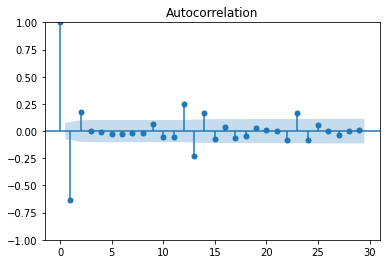

In [19]:
#TIME SPECIFIC ANALYSIS
#Plotting Autocorrelation
sm.graphics.tsa.plot_acf(exploratory_df.GLORAD.diff().diff().diff().dropna())
plt.show()

c:\users\shane\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


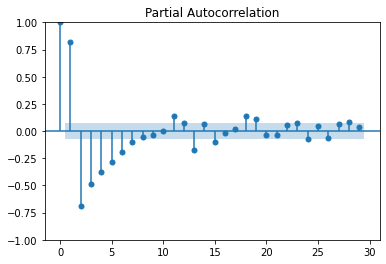

In [20]:
#PLOT PARTIAL AUTOCORRELATION
sm.graphics.tsa.plot_pacf(exploratory_df.GLORAD.values.squeeze())
plt.show()

In [21]:
#Explore the autocorrelation using ADFULLER 
X = dataset['GLORAD'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.808786
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


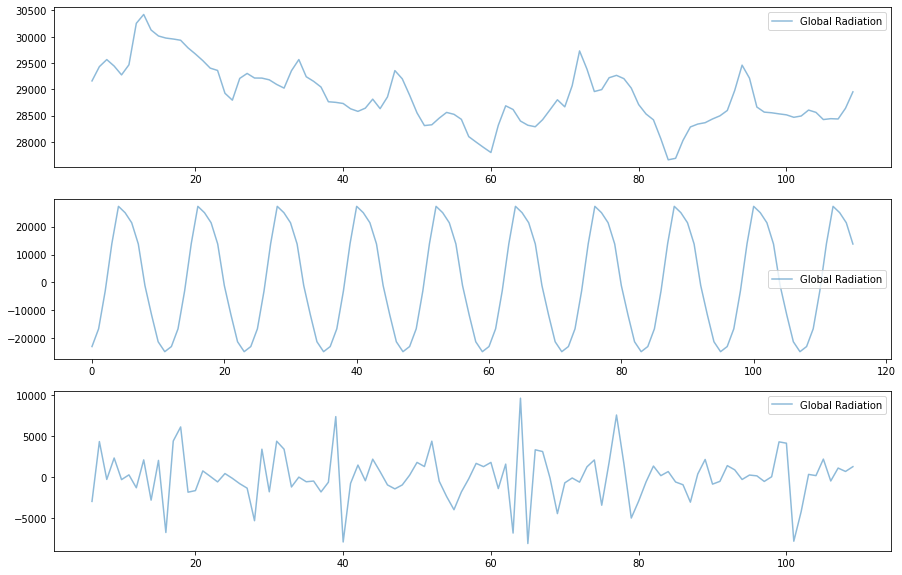

In [22]:
#SEASONALLY DECOMPOSE THE TREND 
seasonal_df = exploratory_df.copy()
seasonal_df = seasonal_df[seasonal_df['LOCATION']=='BELMULLET']
#seasonal_df = seasonal_df[seasonal_df['YEAR'] < 2021]
#seasonal_df = seasonal_df[seasonal_df['YEAR'] > 2018]
from statsmodels.tsa.seasonal import seasonal_decompose as sd
sd_SF = sd(seasonal_df.GLORAD.values, period=12)
plt.figure(figsize=(15,10))
ax1=plt.subplot(311)
ax1.plot(sd_SF.trend, label='Global Radiation', alpha=0.5)
plt.legend()
ax2=plt.subplot(312)
ax2.plot(sd_SF.seasonal, label='Global Radiation', alpha=0.5)
plt.legend()
ax3=plt.subplot(313)
ax3.plot(sd_SF.resid, label='Global Radiation', alpha=0.5)
plt.legend()

In [23]:
#Preprocessing

In [24]:
#Make timeseries - convert date column to datetime - Set date as index - filter to Belmullet
timeseries = dataset.copy()

#convert date to datetime and set as index
timeseries['DATE'] = pd.to_datetime(timeseries['DATE'], dayfirst=True)
timeseries = timeseries.set_index("DATE")
timeseries.index = pd.DatetimeIndex(timeseries.index)

#create year month and named month columns
timeseries['YEAR'] = timeseries.index.year
timeseries['MONTH'] = timeseries.index.month
timeseries['MONTH2'] = timeseries.index.month_name().str.slice(stop=3)

#filter to belmullet
timeseries = timeseries[timeseries['LOCATION'] == 'BELMULLET']
timeseries.head()

,LOCATION,GLORAD,meant,maxtp,mintp,mnmax,mnmin,rain,gmin,wdsp,maxgt,YEAR,MONTH,MONTH2
DATE,,,,,,,,,,,,,,
2012-01-01,BELMULLET,6114,7.9,11.7,1.4,10.1,5.7,123.6,-2.2,14.2,72.0,2012,1,Jan
2012-02-01,BELMULLET,9324,8.4,12.1,-1.0,10.0,6.8,69.4,-4.2,12.8,49.0,2012,2,Feb
2012-03-01,BELMULLET,27674,9.6,22.2,1.8,12.6,6.5,41.4,-2.2,11.8,51.0,2012,3,Mar
2012-04-01,BELMULLET,45504,8.1,13.6,0.7,11.4,4.9,79.7,-2.6,10.6,49.0,2012,4,Apr
2012-05-01,BELMULLET,54903,11.8,26.1,0.6,15.4,8.2,52.1,-2.2,10.1,49.0,2012,5,May


In [25]:
#shift over for lagged inputs
timeseries['LAG_1'] = timeseries['GLORAD'].shift(1)
timeseries['LAG_2'] = timeseries['LAG_1'].shift(1)
timeseries['LAG_3'] = timeseries['LAG_2'].shift(1)
timeseries = timeseries.drop(['2012-01-01', '2012-02-01', '2012-03-01'])

In [26]:
#normalise the continuous features
#continuous_feature_names = ["SYS_DEMAND", "TEMPERATURE", "HUMIDITY", "LIGHTINT", "LAG_1", "LAG_2", "LAG_3"]
#aggregated_normalised = aggregated.copy()
#for feature in continuous_feature_names:
#    aggregated_normalised[[feature]] = normalize(aggregated_normalised[feature].values.reshape(-1, 1), axis=0)
#aggregated_normalised.head()

In [27]:
#Machine Learning models
#Linear Regression (S)ARIMA(X)

In [28]:
#Linear Regression

In [29]:
# Linear Regression train test split
X = timeseries['LAG_1'].values #feature
Y = timeseries['GLORAD'].values #target
size = int(len(X) * 0.66)
x_train, x_test = X[0:size], X[size:len(X)]
y_train, y_test = Y[0:size], Y[size:len(X)]
x_train = x_train.reshape(-1, 1)

# Train the linear regression model
LINREG_model = LinearRegression().fit(x_train, y_train)

In [30]:
#SARIMAX train test split
X = timeseries['GLORAD'].values
eX = timeseries['maxtp'].values.reshape(-1, 1)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
trainEX, testEX = eX[0:size], eX[size:len(X)]

In [31]:
ARIMA_model = pm.auto_arima(train,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=0,
                           start_P=0, seasonal=False,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

ARIMA_model.summary()

SARIMA_model = pm.auto_arima(train,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMA_model.summary()

SARIMAX_model = pm.auto_arima(train, exogenous=trainEX,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1585.443, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1761.168, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1595.506, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1709.280, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1572.824, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1573.649, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1568.808, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1568.403, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1564.834, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1549.383, Time=0.04 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1519.555, Time=0.18 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1499.362, Time=0.21 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   74
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -604.548
Date:                  Fri, 08 Apr 2022   AIC                           1213.095
Time:                          21:56:10   BIC                           1217.349
Sample:                               0   HQIC                          1214.765
                                   - 74                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           300.0415    136.888      2.192      0.028      31.745     568.338
sigma2      1.774e+07   3.61e+06      4.910      0.000    1.07e+07    2.48e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                 1.69
Prob(Q):                              0.42   Prob(JB):                         0.43
Heteroskedasticity (H):               1.11   Skew:                             0.40
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
#Evaluation

In [38]:
#get MAPE of each model
X = timeseries['GLORAD'].values
eX = timeseries['maxtp'].values.reshape(-1, 1)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
testEX = eX[size:len(eX)]

predictions = SARIMAX_model.predict(n_periods=len(test), exogenous = testEX)

results = []
for i in range(len(predictions)):
    results.append([predictions[i], test[i]] )

mape = mean_absolute_percentage_error(test, predictions)
print(mape)

0.1298276190038968


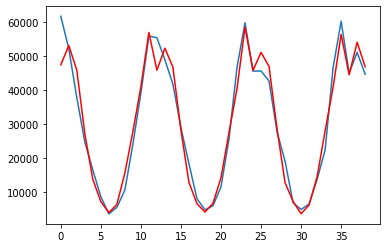

In [39]:
#Make a graph
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()